<!-- Customize the font and markdown size -->
# Custom RL Algorithm with ev2gym gym environment🚗🚗🔋🔋📉
---

This Notebook provides a simple example of how to develop your own custom RL environment using the OpenAI Gym interface. We will use the **simple configuration of ev2gym** for the power *setpoint tracking problem*. We will then train a simple DQN agent to solve the environment.


- ev2gym simulates a Charge Point Operator (CPO) controlling a **fixed number of charging stations** scattered in a city where EVs that arrive and depart.

- The goal of the CPO is to **minimize the difference between the power setpoint and the actual power** consumed by the charging stations.

 - The CPO can control the current(**A**) of each port of each charging station. The current is limited by the **maximum current**(**I**) of the charging station and the **maximum current**(**I**) of the port.



In [1]:
#Install the required packages
%pip install stable-baselines3 gymnasium torch pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch  # 添加這一行來導入 torch
from ev2gym.models.ev2gym_env import EV2Gym
from state import V2G_profit_max
from reward import profit_maximization  # 確保 v2g_profit_reward 定義在 reward.py 中

# 設置裝置
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 加載家庭負載數據
household_loads_df = pd.read_csv(
    '../data/standardlastprofil-haushalte-2023.csv', 
    sep=',', 
    engine='python'
)
household_loads = household_loads_df['SLP-Bandlastkunden HB [kWh]'].values

# 讀取電價資料
electricity_prices_df = pd.read_csv(
    '../data/Day-ahead_prices_202301010000_202401010000_Quarterhour_processed.csv', 
    sep=',', 
    engine='python'
)
electricity_prices = electricity_prices_df['Germany/Luxembourg [€/MWh] Calculated resolutions'].values

# 檢查並替換 NaN 值
electricity_prices = np.nan_to_num(electricity_prices, nan=0.0)

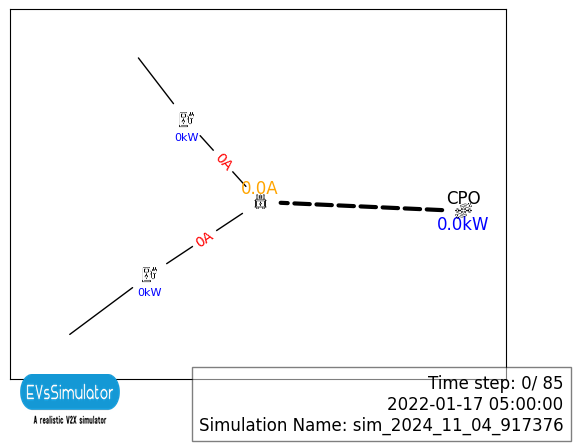

In [4]:
# 創建自定義環境
class CustomEV2Gym(EV2Gym):
    def __init__(self, config_file, household_loads, electricity_prices, *args, **kwargs):
        super().__init__(config_file, *args, **kwargs)
        self.household_loads = household_loads
        self.electricity_prices = electricity_prices
        # 修改觀察空間的範圍來解決兼容性問題
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(28,), dtype=np.float32
        )

# 初始化環境
config_file = "../example_config_files/V2GProfitMax.yaml"
env = CustomEV2Gym(config_file, household_loads, electricity_prices, render_mode=True)

# 設置狀態函數和獎勵函數
low_price_threshold = np.percentile(electricity_prices, 25)
high_price_threshold = np.percentile(electricity_prices, 75)

env.state_function = lambda *args: V2G_profit_max(env, *args)
env.set_reward_function(lambda env_instance, total_costs, user_satisfaction_list, *args: 
    profit_maximization(env_instance, total_costs, user_satisfaction_list, low_price_threshold, high_price_threshold))

# 使用 DummyVecEnv 包裝環境
vec_env = DummyVecEnv([lambda: env])

In [5]:
# 超參數
BATCH_SIZE = 64
GAMMA = 0.95
TAU = 0.005
LR = 1e-3  # 學習率

# 初始化 DDPG 模型
model = DDPG('MlpPolicy', vec_env, learning_rate=LR, batch_size=BATCH_SIZE, gamma=GAMMA, verbose=1, tensorboard_log="./ddpg_ev2gym_tensorboard/")

# 訓練模型
model.learn(total_timesteps=100000, log_interval=10)

# 保存模型
model.save("ddpg_ev2gym_model")

# 測試模型
obs = vec_env.reset()
episode_rewards = []
for _ in range(50):
    obs = vec_env.reset()  # 每次開始新的一個 episode 都重置環境
    episode_reward = 0
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        episode_reward += reward
    episode_rewards.append(episode_reward)



Using cpu device
Logging to ./ddpg_ev2gym_tensorboard/DDPG_5


KeyboardInterrupt: 

In [6]:
# 打印和繪製結果
print("Episode rewards:", episode_rewards)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Testing Results')
plt.show()

NameError: name 'episode_rewards' is not defined

Example reward function that penalizes the squared difference between the minimum of the power setpoint or the power potential and the actual power consumed by the charging stations.

$$
R(s_t,a_t,s_{t+1}) = - (min(P^{setpoint}, P^{potential}) - P^{actual})^2
$$

Plot other metrics from the info dictionary returned by the environment. For example, the number of times the agent charged or discharged the EVs.